In [1]:
!python -V

Python 3.10.8


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [6]:
import os

os.chdir('..')

In [7]:
df = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')

print("Number of columns:", len(df.columns))

df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df['duration'].describe()
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

print("Standard deviation of duration", np.nanstd(df['duration']))


Number of columns: 19
Standard deviation of duration 42.59434429744777


Dataset Profiling

In [8]:
print('Percentage of records left after removing outliers', len(df[(df.duration >= 1) & (df.duration <= 60)])/len(df) * 100, '%')

Percentage of records left after removing outliers 98.1220282212598 %


In [9]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [10]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

print('Training dimensionality:', X_train.shape[1])

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print('Linear Regression in Validation data RMSE: ')
mean_squared_error(y_train, y_pred, squared=False)

Training dimensionality: 516
Linear Regression in Validation data RMSE: 


/Users/joaofonseca/git/mlops_zoom_camp/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.658813384236691

/var/folders/sl/1cr8n5zd20q60q8z__fh6q140000gp/T/ipykernel_65670/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/sl/1cr8n5zd20q60q8z__fh6q140000gp/T/ipykernel_65670/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, lab

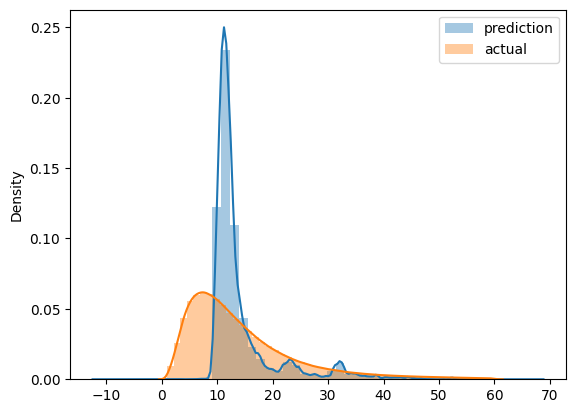

In [11]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [12]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [13]:
df_train = read_dataframe('./data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2023-02.parquet')

In [14]:
len(df_train), len(df_val)

(3009173, 2855951)

In [15]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [16]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [17]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

print('Linear Regression in Validation data RMSE: ')
mean_squared_error(y_val, y_pred, squared=False)

Linear Regression in Validation data RMSE: 


/Users/joaofonseca/git/mlops_zoom_camp/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


5.256227422749583

In [19]:
# Define the file path
file_path = 'models/lin_reg.pkl'

# Create the directory if it doesn't exist
directory = os.path.dirname(file_path)
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the model to the file
with open(file_path, 'wb') as file:
    pickle.dump(lr, file)

In [20]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [21]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/Users/joaofonseca/git/mlops_zoom_camp/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.395699095576239